<a href="https://colab.research.google.com/github/begumtekoz/time-series-forecasting-by-deep-learning/blob/main/forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Time Series Forecasting using Deep Learning**


Many industries are struggling with early identification of quality issues. Improving the quality
process is very important for reducing production costs and increasing customer satisfaction.
Processes such as how often the malfunctions occur during the warranty period and how often the error frequency is are among the frequently asked questions in all areas of the industry. Being able
to predict these questions helps to minimize the error in the products.






It is applied Deep Learning Algorithm to forecast the number of failure daily. This is the final notebook. The other notebooks that I used to find the parameters, trials etc are supplied if it is necessary.

## Library


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
import torch.nn.functional as F

## Installing and Visualing Data

**30-day forecasted dataset using Autoarima, which is taken from the company** (Just comparison)

In [ ]:
## It is  imported the necessary packages to access my Google drive
from google.colab import files #import the library to access my google drive
uploaded = files.upload()

Saving forecast.xlsx to forecast (1).xlsx


In [ ]:
import io
# read the full data
forecast = pd.read_excel(io.BytesIO(uploaded['forecast.xlsx']))

forecast.head() #show the first 5 observation.

,forecast
0,150.824219
1,211.561579
2,177.084303
3,188.664827
4,169.235018


**Main Dataset, which is used in this project**

In [ ]:
## It is imported the necessary packages to access my Google drive
from google.colab import files #import the library to access my google drive
uploaded = files.upload()

Saving projedata2.504.xlsx to projedata2.504 (1).xlsx


## Exploratory Data Analysis

In the Exploratory data analysis section, the features of the data set to be forecasted will be examined. The first five observation is shown in the below.

In [ ]:
import io
# read the full data
data = pd.read_excel(io.BytesIO(uploaded['projedata2.504.xlsx']))

data.head() #show the first 5 observation.

,Date,Claim,WorkingHour,TotalCost,Emp.Cost
0,2017-01-01,102,70003,34429.39,8326.15
1,2017-01-02,371,278191,96341.98,24015.95
2,2017-01-03,270,186141,71683.19,18189.60
3,2017-01-04,253,214060,60816.27,13216.90
4,2017-01-05,321,197866,83631.91,18845.45


There are 1811 observations and 5 variables in the dataset.


In [ ]:
data.shape#shape of the data

(1811, 5)

The descriptive statistics are in the below. The average claim is 217.

In [ ]:
## Get descriptive stats

data[["Claim","WorkingHour","TotalCost","Emp.Cost"]].describe()

,Claim,WorkingHour,TotalCost,Emp.Cost
count,1811.000000,1811.000000,1811.000000,1811.000000
mean,217.238542,134564.171176,92339.760745,19525.758840
std,136.248483,89315.915047,47842.522151,9967.934976
min,3.000000,2415.000000,2061.400000,214.400000
25%,110.000000,59478.500000,55879.650000,11793.150000
50%,191.000000,117287.000000,93619.850000,20483.850000
75%,311.500000,203269.500000,126753.035000,26984.400000
max,685.000000,654474.000000,251659.020000,49417.100000


The dataset contains claim data from the first day of January 2017 to the 23rd of December 2021.

In [ ]:
print (data["Date"].min())
print (data["Date"].max())

2017-01-01 00:00:00
2021-12-23 00:00:00


The types of variable in the dataset is given in the below.

In [ ]:
data[["Date","Claim","WorkingHour","TotalCost","Emp.Cost"]].dtypes

Date           datetime64[ns]
Claim                   int64
WorkingHour             int64
TotalCost             float64
Emp.Cost              float64
dtype: object

In [ ]:
resp = data.iloc[:,1:2].values # extract target value production
features = data.iloc[:,1:3].values #extract the features

In [ ]:
resp.shape

(1811, 1)

In [ ]:
features.shape

(1811, 2)

**Time Based Failure Requests**

In [ ]:
fig_size = plt.rcParams["figure.figsize"] #increase the figure size.
fig_size[0] = 15
fig_size[1] = 7.5
plt.rcParams["figure.figsize"] = fig_size

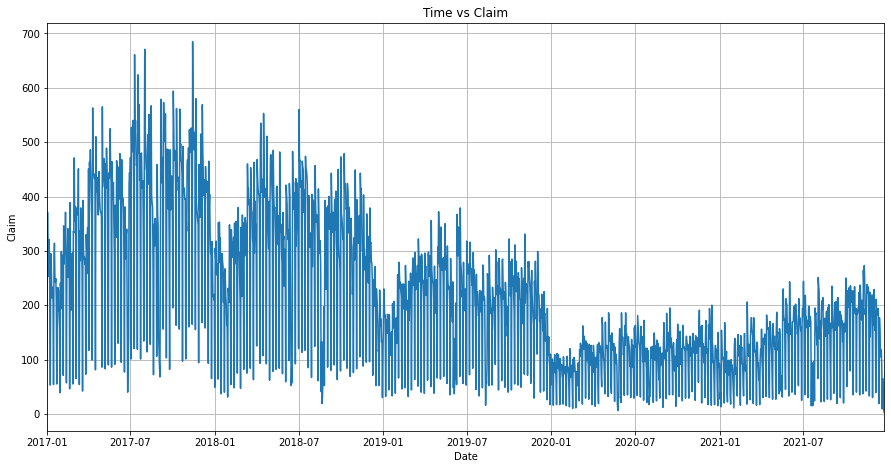

In [ ]:
plt.title('Time vs Claim')
plt.ylabel('Claim')
plt.xlabel('Date')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(data.Date, resp) #plot of production

The dataset contains claim data from the first day of January 2017 to the 23rd of December 2021. The number of faults from 2017 to 2020 is very high. After the first month of 2020, there has been a steep decrease in the number of daily failures. The reason for this is the discontinuation of the models that caused the malfunction and the improvement in the quality of the parts.


It is right skewed. Data skewed to the right is usually a result of a lower boundary in a data set (whereas data skewed to the left is a result of a higher boundary). So if the data set's lower bounds are extremely low relative to the rest of the data, this will cause the data to skew right.



Text(0.5, 1.0, 'Distribution of Claim')

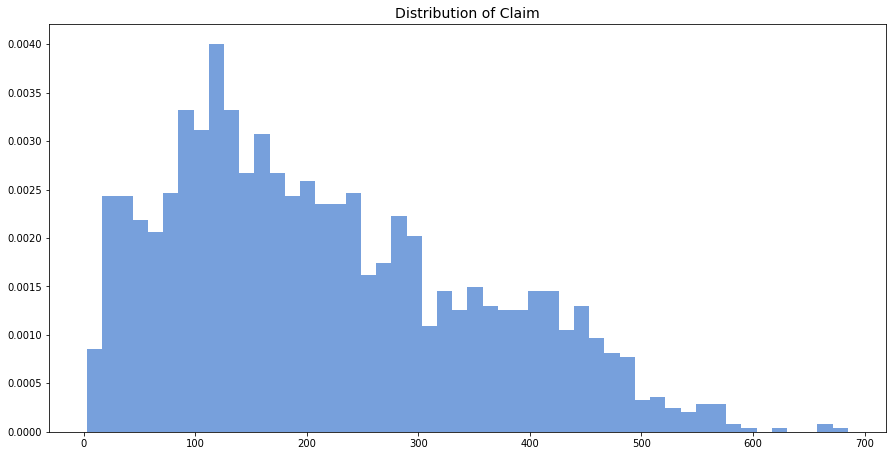

In [ ]:
plt.hist(data.Claim, 50, density=True, color='#4A80D1', alpha=0.75)
plt.title("Distribution of Claim",size =14)

**Time Based Working Hour**

No handles with labels found to put in legend.


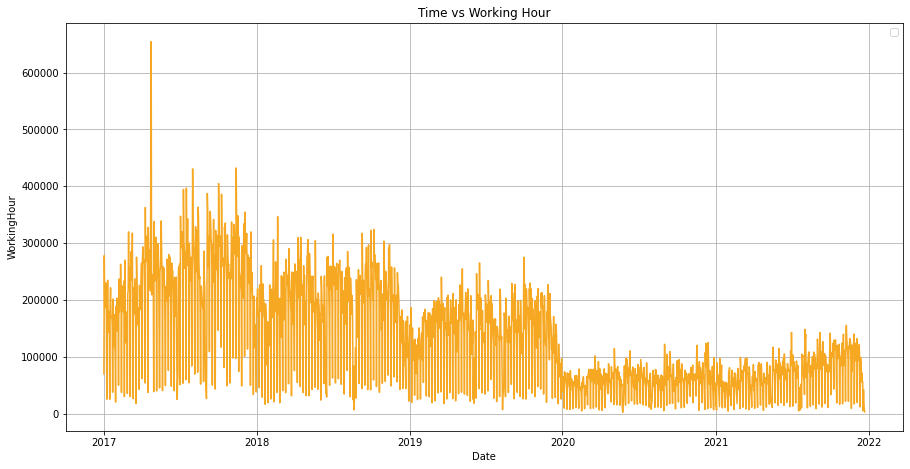

In [ ]:
#plot of working hour
plt.legend(loc='best')
plt.title('Time vs Working Hour')
plt.ylabel('WorkingHour')
plt.xlabel('Date')
plt.grid(True)
plt.plot(data.Date, data.WorkingHour,color='#F7A822')
plt.show()


Text(0.5, 1.0, 'Distribution of Working Hour')

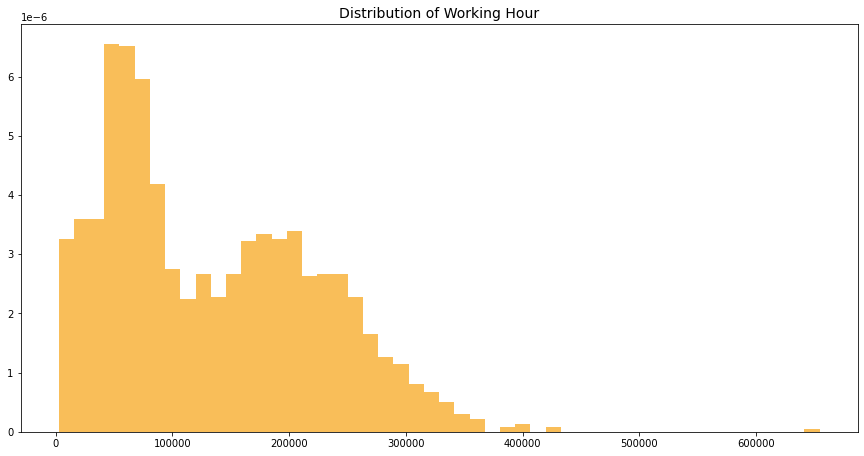

In [ ]:
plt.hist(data.WorkingHour, 50, density=True, color='#F7A822', alpha=0.75)
plt.title("Distribution of Working Hour",size =14)

## Dataloading

I will apply sliding windows on the response to create my features. Moreover, I will scale both my features and target variable. Then, I will create the arrays into tensor object.

In [ ]:
def sliding_windows(resp,features, seq_length):
    x = []
    y = []

    for i in range(len(resp)-seq_length-1):
        _x = features[i:(i+seq_length)]
        _y = resp[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
resp_scale = sc.fit_transform(resp)
f_scale  = sc.fit_transform(features)
seq_length = 24 #lag of input
x, y = sliding_windows(resp_scale,f_scale, seq_length)

Lag number was chosen as 24.

In [ ]:
dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

In [ ]:
dataX.shape

torch.Size([1786, 24, 2])

In [ ]:
trainX = Variable(torch.Tensor(np.array(x[0:1756]))) #1756 is the index number seperating train and test data.
trainY = Variable(torch.Tensor(np.array(y[0:1756])))

testX = Variable(torch.Tensor(np.array(x[1756:len(x)])))
testY = Variable(torch.Tensor(np.array(y[1756:len(y)])))

In [ ]:
dataX.shape

torch.Size([1786, 24, 2])

In [ ]:
dataY.shape

torch.Size([1786, 1])

30 days of data reserved for testing. The lag is 24.

In [ ]:
testX.shape

torch.Size([30, 24, 2])

In [ ]:
trainX.shape

torch.Size([1756, 24, 2])

## LSTM Model

LSTM model is applied in this section.

In [ ]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()

        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))

        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))

        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))

        h_out = h_out.view(-1, self.hidden_size)

        out = self.fc(h_out)

        return out

In [ ]:
input_size = 2 #define the optimal parameters
hidden_size = 10
num_layers = 1
num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)
print(lstm)

LSTM(
  (lstm): LSTM(2, 10, batch_first=True)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)


##Training


In [ ]:
num_epochs = 3000
learning_rate = 0.01
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_list = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()

    # obtain the loss function
    loss = criterion(outputs, trainY)
    loss_list.append(loss)
    loss.backward()

    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.24011
Epoch: 100, loss: 0.01917
Epoch: 200, loss: 0.01866
Epoch: 300, loss: 0.01852
Epoch: 400, loss: 0.01841
Epoch: 500, loss: 0.01821
Epoch: 600, loss: 0.01761
Epoch: 700, loss: 0.01398
Epoch: 800, loss: 0.00946
Epoch: 900, loss: 0.00525
Epoch: 1000, loss: 0.00454
Epoch: 1100, loss: 0.00423
Epoch: 1200, loss: 0.00402
Epoch: 1300, loss: 0.00385
Epoch: 1400, loss: 0.00376
Epoch: 1500, loss: 0.00362
Epoch: 1600, loss: 0.00351
Epoch: 1700, loss: 0.00367
Epoch: 1800, loss: 0.00323
Epoch: 1900, loss: 0.00316
Epoch: 2000, loss: 0.00312
Epoch: 2100, loss: 0.00308
Epoch: 2200, loss: 0.00301
Epoch: 2300, loss: 0.00303
Epoch: 2400, loss: 0.00295
Epoch: 2500, loss: 0.00320
Epoch: 2600, loss: 0.00284
Epoch: 2700, loss: 0.00280
Epoch: 2800, loss: 0.00272
Epoch: 2900, loss: 0.00386


Text(0.5, 1.0, 'Loss Graph for LSTM')

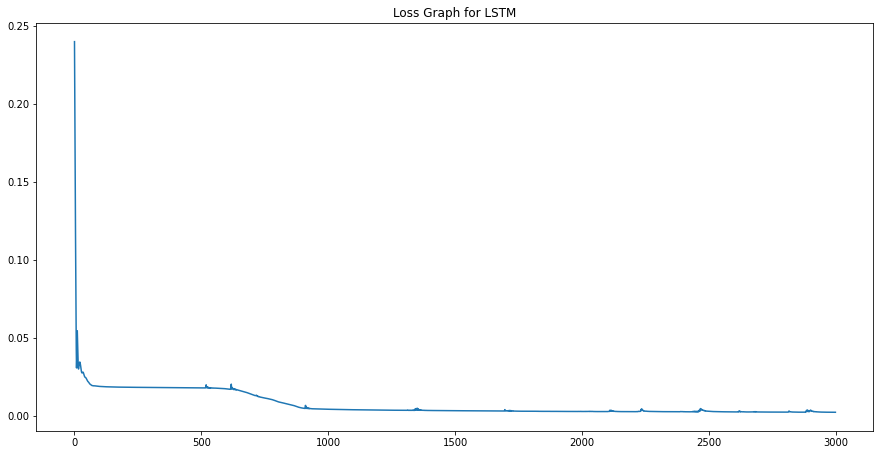

In [ ]:
plt.plot(loss_list)
plt.title("Loss Graph for LSTM") #convergence is achieved

## Testing My Model

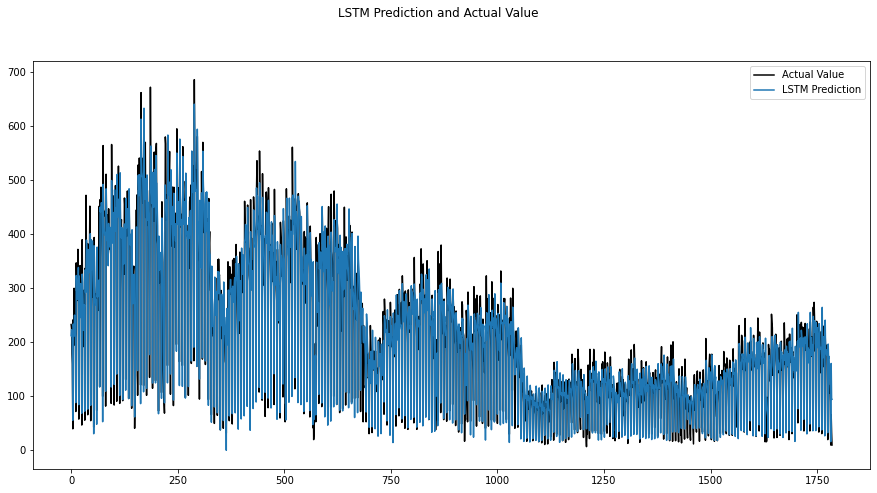

In [ ]:
lstm.eval()
train_predict_lstm = lstm(dataX) #full data
data_predict_lstm = train_predict_lstm.data.numpy() #convert into numpy
dataY_plot = dataY.data.numpy() #convert the series into numpy array
data_predict_lstm =data_predict_lstm * (resp.max() - resp.min()) + resp.min() #back transformation.
dataY_plot =dataY_plot * (resp.max() - resp.min()) + resp.min()
plt.plot(dataY_plot,label ='Actual Value',color = 'black')
plt.plot(data_predict_lstm,label='LSTM Prediction')
plt.suptitle('LSTM Prediction and Actual Value')
plt.legend(loc='best')
plt.show()

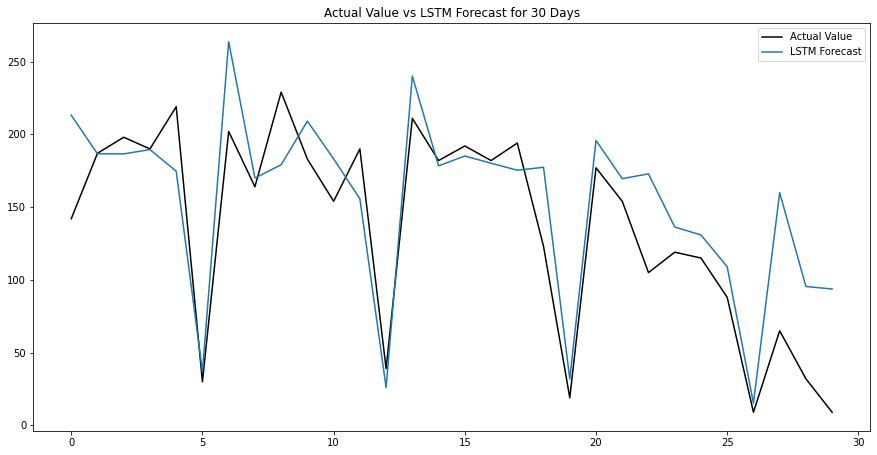

In [ ]:
data_predict_lstm_test = data_predict_lstm[1756:len(x)] #extract the forecast value
dataY_plot_test = dataY_plot[1756:len(x)] #actual value for 30 Days
plt.plot(dataY_plot_test,label = "Actual Value",color ='black')
plt.plot(data_predict_lstm_test,label ="LSTM Forecast")
plt.title('Actual Value vs LSTM Forecast for 30 Days')
plt.legend(loc='best')
plt.show()

In [ ]:
#mse and rmse
error = (data_predict_lstm_test-dataY_plot_test)**2
mse = error.mean() #mse
print("MSE:", mse,"RMSE:",mse**(0.5))

MSE: 1574.3019 RMSE: 39.67747320436134


In [ ]:
#mean absolute error
error1 = (data_predict_lstm_test-dataY_plot_test)
abs_error = abs(error1)
abs_error_mean = abs_error.mean()
print("MAE:",abs_error_mean)

MAE: 29.5918



## RNN (Recurrent Neural Network)



In this section, RNN is applied.

In [ ]:
class RNN(nn.Module):

    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNN, self).__init__()

        # Number of hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.layer_dim = layer_dim

        # RNN
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, nonlinearity='relu')

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):

        # Initialize hidden state with zeros
        h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))

        # One time step
        out, hn = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
input_dim = 2   # input dimension
hidden_dim = 10 # hidden layer dimension
layer_dim =10  # number of hidden layers
output_dim = 1  # output dimension

rnn = RNN(input_dim, hidden_dim, layer_dim, output_dim)
print(rnn)

RNN(
  (rnn): RNN(2, 10, num_layers=10, batch_first=True)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)


In [ ]:
num_epochs = 3000
learning_rate = 0.01
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_list = []
# Train the model
for epoch in range(num_epochs):
    outputs = rnn(trainX)
    optimizer.zero_grad()

    # obtain the loss function
    loss = criterion(outputs, trainY)
    loss_list.append(loss)
    loss.backward()

    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.34336
Epoch: 100, loss: 0.04029
Epoch: 200, loss: 0.04047
Epoch: 300, loss: 0.04047
Epoch: 400, loss: 0.04047
Epoch: 500, loss: 0.04047
Epoch: 600, loss: 0.04047
Epoch: 700, loss: 0.04047


In [ ]:
plt.plot(loss_list)
plt.title("Loss Graph for RNN") #convergence is achieved

In [ ]:
rnn.eval()
train_predict_rnn = rnn(dataX) #get the predicted value
data_predict_rnn = train_predict_rnn.data.numpy() #convert it numpy array
dataY_plot = dataY.data.numpy() #get the data
data_predict_rnn =data_predict_rnn * (resp.max() - resp.min()) + resp.min() #back transformation.
dataY_plot =dataY_plot * (resp.max() - resp.min()) + resp.min()
plt.plot(dataY_plot,color = 'black',label = 'Actual Value')
plt.plot(data_predict_rnn,label = 'RNN Prediction')
plt.suptitle('RNN Prediction and Actual Value')
plt.legend(loc='best')
plt.show()

In [ ]:
test_predict_rnn = data_predict_rnn[1756:len(x)] #forecast values for 30 Days
dataY_plot_test = dataY_plot[1756:len(x)] #actual observation for 30 Days
plt.plot(dataY_plot_test,label = "Actual Value",color ='black')
plt.plot(test_predict_rnn,label ="RNN Forecast")
plt.title('Actual Value vs RNN Forecast for 30 Days')
plt.xlabel('Days')
plt.legend(loc='best')
plt.show()

In [ ]:
#rmse
error11 = (test_predict_rnn-dataY_plot_test)**2
mse1 = error11.mean() #mse
print("MSE:", mse1,"RMSE:",mse1**(0.5))

In [ ]:
#mae
error2 = (test_predict_rnn-dataY_plot_test)
abs_error1 = abs(error2)
abs_error_mean1 = abs_error1.mean()
print("MAE:",abs_error_mean1)

## CNN (Convolutional Neural Network)


In [ ]:
class CNN1d(nn.Module):
    def __init__(self, input_size, output_size):
        super(CNN1d, self).__init__()

        self.conv1 = nn.Conv1d(input_size, 64, kernel_size=1, stride=1)
        self.pool1 = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(64,32,kernel_size=2, stride = 1, padding=1)
        self.fc1 = nn.Linear(64, output_size)
        self.fc2 = nn.Linear(1, 1)

    def forward(self, x):
        in_size1 = x.size(0)  # one batch
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = x.view(in_size1, -1)  # flatten the tensor
        x = self.fc1(x)
        output = self.fc2(x)

        return output

In [ ]:
input_size = 24   # input dimension
output_size = 1  # output dimension

model = CNN1d(input_size, output_size)
print(model)

In [ ]:
num_epochs = 3000
learning_rate = 0.01
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_list = []
# Train the model
for epoch in range(num_epochs):
    outputs = model(trainX)
    optimizer.zero_grad()

    # obtain the loss function
    loss = criterion(outputs, trainY)
    loss_list.append(loss)
    loss.backward()

    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

In [ ]:
plt.plot(loss_list) #convergence is achieved
plt.title("Loss plot of Training for CNN")

In [ ]:
model.eval()
train_predict_cnn = model(trainX) #get the predicted value
data_predict_cnn = train_predict_cnn.data.numpy() #convert them into numpy array
dataY_plot = dataY.data.numpy() #the actual observation in numpy format
data_predict_cnn =data_predict_cnn * (resp.max() - resp.min()) + resp.min() #back transformation.
dataY_plot =dataY_plot * (resp.max() - resp.min()) + resp.min()
plt.plot(dataY_plot,label = 'Actual Value',color = 'black')
plt.plot(data_predict_cnn,label="CNN Prediction")
plt.title('Actual Value vs CNN Prediction')
plt.xlabel('Time')
plt.legend(loc='best')
plt.show()

In [ ]:
test_predict_cnn = model(testX) #produce forecast
test_predict_cnn = test_predict_cnn.data.numpy() #convert it into numpy
#testY = testY.data.numpy()
test_predict_cnn =test_predict_cnn * (resp.max() - resp.min()) + resp.min() #back transformation.


In [ ]:
test_Y = testY  * (resp.max() - resp.min()) + resp.min() #back transformation of the test data
test_Y=test_Y.numpy() #convert it into numpy
plt.plot(test_Y,label = 'Test Value',color = 'black')
plt.plot(test_predict_cnn,label = 'CNN Forecast')
plt.xlabel('Time')
plt.legend(loc ='best')
plt.suptitle('Actual Value and CNN Forecast for Next 30 Days')

In [ ]:
## RMSE
error3 = (test_predict_cnn-test_Y)**2
mse3 = error3.mean() #mse
rmse3= mse3**(0.5)
print("MSE:",mse3,"RMSE:",rmse3)

In [ ]:
# MAE
error4 = (test_predict_cnn-test_Y)
error5 = abs(error4)
mae = error5.mean()
print("MAE:",mae)

## Accuracy Measures for Company Forecast

In [ ]:
test_Y = testY  * (resp.max() - resp.min()) + resp.min() #back transformation on the actual data
test_Y=test_Y.numpy() #convert it into numpy
f = forecast.forecast.to_numpy() #convert NWP forecast to numpy
f = f.reshape((30, 1)) #reshape it

## RMSE
error6 = (f-test_Y)**2
mse4 = error6.mean() #mse
rmse4= mse4**(0.5)
print("MSE:",mse4,"RMSE:",rmse4)

In [ ]:
# MAE
error6 = (f-test_Y)
error7 = abs(error6)
mae = error7.mean()
print("MAE:",mae)

In [ ]:
# Visualization of actual value and forecast value for 30 Days
plt.plot(dataY_plot_test,label = "Actual Value",color ='black')
plt.plot(test_predict_rnn,label ="RNN Forecast")
plt.plot(data_predict_lstm_test,label ="LSTM Forecast")
plt.plot(forecast.forecast,label ="Company Forecast")
plt.plot(test_predict_cnn,label = 'CNN Forecast')
plt.title('Actual Value vs Forecasts for 30 Days')
plt.legend(loc='best')
plt.xlabel('Days')
plt.ylabel('Production(MWh)')
plt.grid(True)
plt.show()

In this section, we will compare the 30-day forecast results. The Autoarima forecast used in the company and the LSTM, RNN and CNN results we tried in this study will be observed. Considering the RMSE values, the best results were obtained with LSTM. The RMSE values are the company's estimate, CNN, RNN and LSTM are 82, 43, 38 and 28 respectively.

## Forecast Comparison for 7 days

In this section, the 7-day forecast results will be compared. The Auto Arima forecast used in the company and the LSTM, RNN and CNN results in this study will be compared.

**LSTM**

In [ ]:
data_predict_lstm_test_7days= data_predict_lstm[1779:len(x)] #forecast of LSTM for 7days
dataY_plot_test_7days = dataY_plot[1779:len(x)] #actual value for 7days
plt.plot(dataY_plot_test_7days,label = "Actual Value",color ='black')
plt.plot(data_predict_lstm_test_7days,label ="LSTM Forecast")
plt.title('Actual Value vs LSTM Forecast for 7 Days')
plt.legend(loc='best')
plt.show()

In [ ]:
#RMSE
error_7days= (data_predict_lstm_test_7days-dataY_plot_test_7days)**2
mse_7days = error_7days.mean() #mse
print("MSE:", mse_7days,"RMSE:",mse_7days**(0.5))

In [ ]:
#MAE
error1_lstm_7days = (data_predict_lstm_test_7days-dataY_plot_test_7days)
abs_error_lstm_7days = abs(error1_lstm_7days)
abs_error_lstm_7days_mean = abs_error_lstm_7days.mean()
print("MAE:",abs_error_lstm_7days_mean)

**RNN**


In [ ]:
test_predict_rnn_7days = data_predict_rnn[1779:len(x)]#prediction
dataY_plot_test_7days  = dataY_plot[1779:len(x)] #actual
plt.plot(dataY_plot_test_7days ,label = "Actual Value",color ='black')
plt.plot(test_predict_rnn_7days ,label ="RNN Forecast")
plt.title('Actual Value vs RNN Forecast for 7 Days')
plt.xlabel('Hour')
plt.legend(loc='best')
plt.show()

In [ ]:
error_7days_rnn = (test_predict_rnn_7days -dataY_plot_test_7days)**2 #calculate square error
mse_7days_rnn = error_7days_rnn.mean() #mse
print("MSE:", mse_7days_rnn,"RMSE:",mse_7days_rnn**(0.5))

In [ ]:
error1_rnn_7days = (test_predict_rnn_7days -dataY_plot_test_7days)
abs_error_rnn_7days = abs(error1_rnn_7days)
abs_error_rnn_7days_mean = abs_error_rnn_7days.mean()
print("MAE:",abs_error_rnn_7days_mean)

**CNN**


In [ ]:
test_predict_cnn_7days =test_predict_cnn[23:30]
test_Y_7days = test_Y[23:30]
plt.plot(test_Y_7days,label = 'Test Value',color = 'black')
plt.plot(test_predict_cnn_7days,label = 'CNN Forecast')
plt.xlabel('Time')
plt.legend(loc ='best')
plt.suptitle('Actual Value and CNN Forecast for Next 7 Days')

In [ ]:
error3_7days = (test_predict_cnn_7days-test_Y_7days)**2
mse3_7days = error3_7days.mean() #mse
rmse3_7days= mse3_7days**(0.5)
print("MSE:",mse3_7days,"RMSE:",rmse3_7days)

In [ ]:
error1_cnn_7days = (test_predict_cnn_7days-test_Y_7days)
abs_error_cnn_7days = abs(error1_cnn_7days)
abs_error_cnn_7days_mean = abs_error_cnn_7days.mean()
print("MAE:",abs_error_cnn_7days_mean)

**Company Forecast**

In [ ]:
#MSE Calculation
f7 = f[23:30] #company forecast for 7 Days
error6_7days = (f7-test_Y_7days)**2
mse4_7days = error6_7days.mean() #mse
rmse4_7days= mse4_7days**(0.5)
print("MSE:",mse4_7days,"RMSE:",rmse4_7days)

In [ ]:
#MAE
error1_c_7days = (f7-test_Y_7days)
abs_error_c_7days = abs(error1_c_7days)
abs_error_c_7days_mean = abs_error_c_7days.mean()
print("MAE:",abs_error_c_7days_mean)

In [ ]:
# Visualization of actual value and forecast value for 7 Days
plt.plot(test_Y_7days,label = "Actual Value",color ='black')
plt.plot(test_predict_rnn_7days,label ="RNN Forecast")
plt.plot(data_predict_lstm_test_7days,label ="LSTM Forecast")
plt.plot(f7,label ="Company Forecast")
plt.plot(test_predict_cnn_7days,label = 'CNN Forecast')
plt.title('Actual Value vs Forecasts for 7 Days')
plt.legend(loc='best')
plt.xlabel('Hour')
plt.ylabel('Production(MWh)')
plt.grid(True)
plt.show()

When we compare the results of the 7-day test data, the company estimate is far from the actual observations. The closest results were LSTM, RNN and CNN, respectively.